In [1]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_dir = '../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

In [3]:
off_speed = all_pitches[all_pitches['TaggedPitchType'].isin(['ChangeUp','Splitter'])]

In [4]:
off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_21944\3639497680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)


In [5]:
os_preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [6]:
off_speed_X = off_speed[os_preds]
off_speed_y = off_speed['whiff']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(off_speed_X, off_speed_y, test_size=.33)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.85%


In [8]:
all_preds = model.predict_proba(off_speed_X)[:,1]
mean_pred = np.mean(all_preds)

print(mean_pred)

0.15439457


In [9]:
# Get unique values
unique_values = off_speed['Pitcher'].unique()

# Create a dictionary to store subsets
subsets = {value: off_speed[off_speed['Pitcher'] == value] for value in unique_values}

In [10]:
g_graves = subsets['Herberholz, Christian']
g_graves_X = g_graves[os_preds]

whiff_preds = model.predict_proba(g_graves_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Griffin Graves off-speed stuff+:{np.mean(stuff*100)}")

Griffin Graves off-speed stuff+:130.20558166503906


In [12]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls) 

def draw_home_plate(catcher_perspective=True, ls='k-'):
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else: 
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

def draw_attack_zones():
  # outer heart / inner shadow
  plt.plot([-0.558, 0.558], [1.833,1.833], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, -0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([0.558, 0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, 0.558], [3.166,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3) 

  # outer shadow /  inner chase 
  plt.plot([-1.108, 1.108], [1.166,1.166], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, -1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([1.108, 1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, 1.108], [3.833,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3) 

  # outer chase 
  plt.plot([-1.666, 1.666], [0.5,0.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, -1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([1.666, 1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, 1.666], [4.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3) 

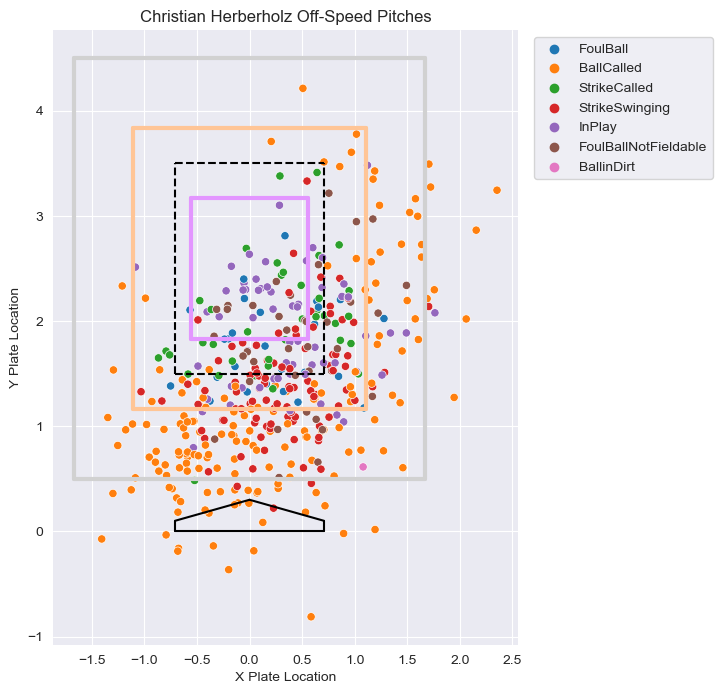

In [27]:
fig = plt.figure(figsize=(6,9))
fig = sns.scatterplot(data=g_graves, x='PlateLocSide', y='PlateLocHeight', 
                      hue='PitchCall')

draw_sz(ls='k--')
draw_home_plate(False)
draw_attack_zones()
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine(left=True, bottom=True)
plt.title('Christian Herberholz Off-Speed Pitches')
plt.xlabel('X Plate Location')
plt.ylabel('Y Plate Location')
plt.show()

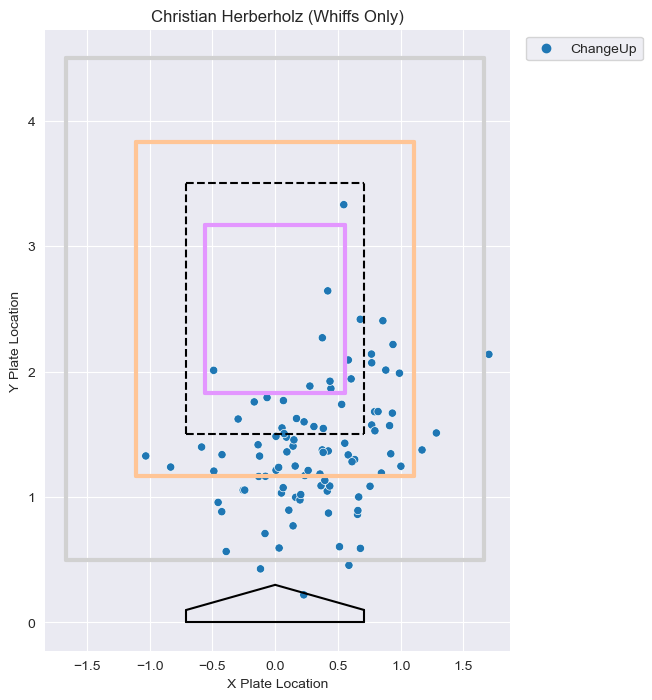

In [28]:
fig = plt.figure(figsize=(6,9))
fig = sns.scatterplot(data=g_graves[g_graves['PitchCall'] == 'StrikeSwinging'], x='PlateLocSide', y='PlateLocHeight',
                      hue='TaggedPitchType')

draw_sz(ls='k--')
draw_home_plate(False)
draw_attack_zones()
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine(left=True, bottom=True)
plt.title('Christian Herberholz (Whiffs Only)')
plt.xlabel('X Plate Location')
plt.ylabel('Y Plate Location')
plt.show()